### intial set-up

insert from URL instead of local CSV
calculate number of outliers in descriptive

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sb
pd.set_option('display.max_columns', None) #all columns are displayed
pd.set_option('display.max_rows', None) #all rows are displayed

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine = pd.read_csv(url, sep=';')
wine.isnull().sum()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Data split & Outliers

In [3]:
from sklearn.model_selection import train_test_split
xwine = wine.drop('quality', axis =1)
xtrn, xtst, ytrn, ytst = train_test_split(xwine, wine['quality'], random_state = 42, test_size = 0.2)
#xtrn features 80%, xtst 20%
#ytrn labels 80%, ytst 20%

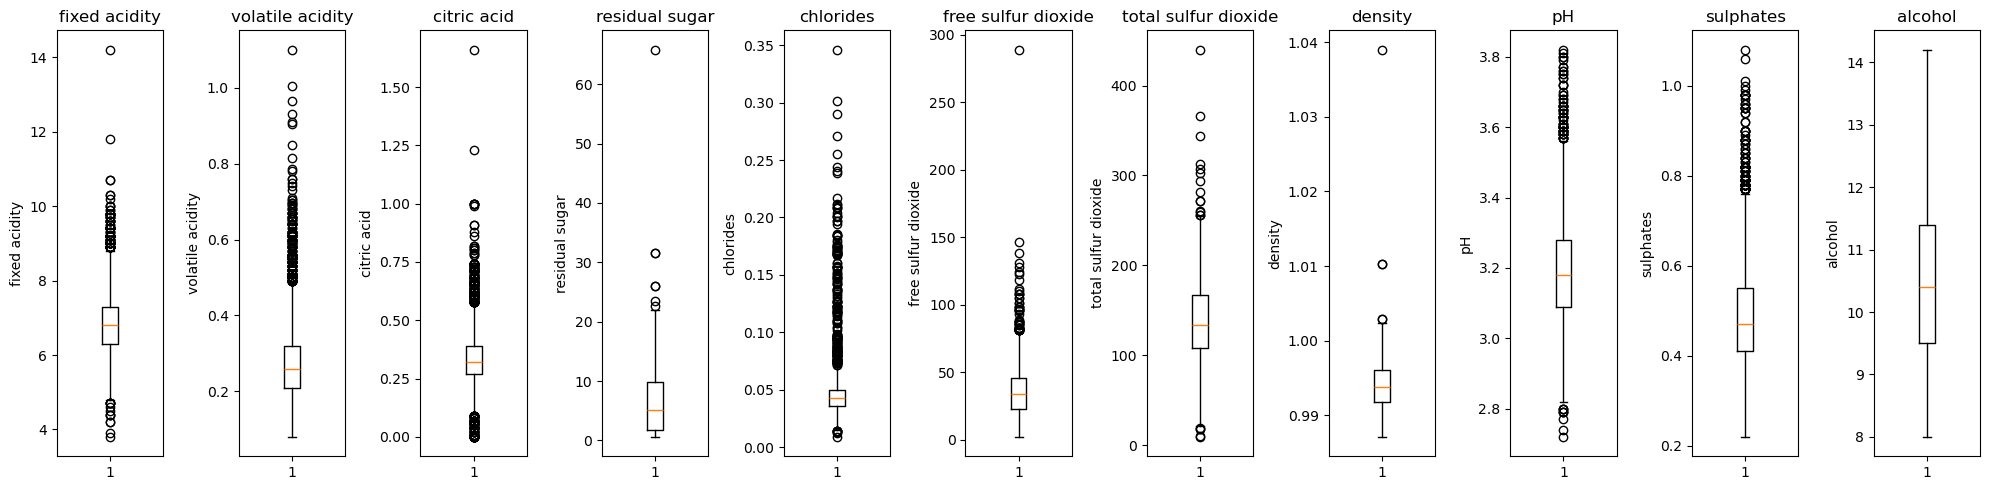

In [4]:
columns_to_plot = [col for col in xwine.columns]

fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(20, 5))

for ax, col in zip(axes, columns_to_plot):
    ax.boxplot(xwine[col])
    ax.set_title(f'{col}')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


### Model Training

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor(n_neighbors=1)
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(xtrn, ytrn)
knn_y_pred = knn.predict(xtst)

knr.fit(xtrn, ytrn)
knr_y_pred = knr.predict(xtst)

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
rmse = root_mean_squared_error (ytst, knn_y_pred)
mae = mean_absolute_error(ytst, knn_y_pred)

print("RMSE", rmse)
print("MAE", mae)


RMSE 0.8777289805317505
MAE 0.5275510204081633


### note 
would be nice to plot the knn prob results and the distance towards the actuals. mlxtend is not supported by anaconda, asked Ilias


### Pipeline & cross validation

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
scaler = StandardScaler()

In [7]:
knr_pipe = make_pipeline(scaler,knr)
knn_pipe = make_pipeline(scaler,knn)
knr_pipe.fit(xtrn, ytrn)
knn_pipe.fit(xtrn, ytrn)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [8]:
from sklearn.model_selection import cross_val_score
knn_mse = -cross_val_score(knn_pipe, xtrn, ytrn, scoring = 'neg_mean_squared_error', cv = 5)
pd.DataFrame(knn_mse).describe()

,0
count,5.000000
mean,0.665896
std,0.025011
min,0.643678
25%,0.654337
50%,0.655612
75%,0.667944
max,0.707908


no 1 or 2 labels in the ytrn data

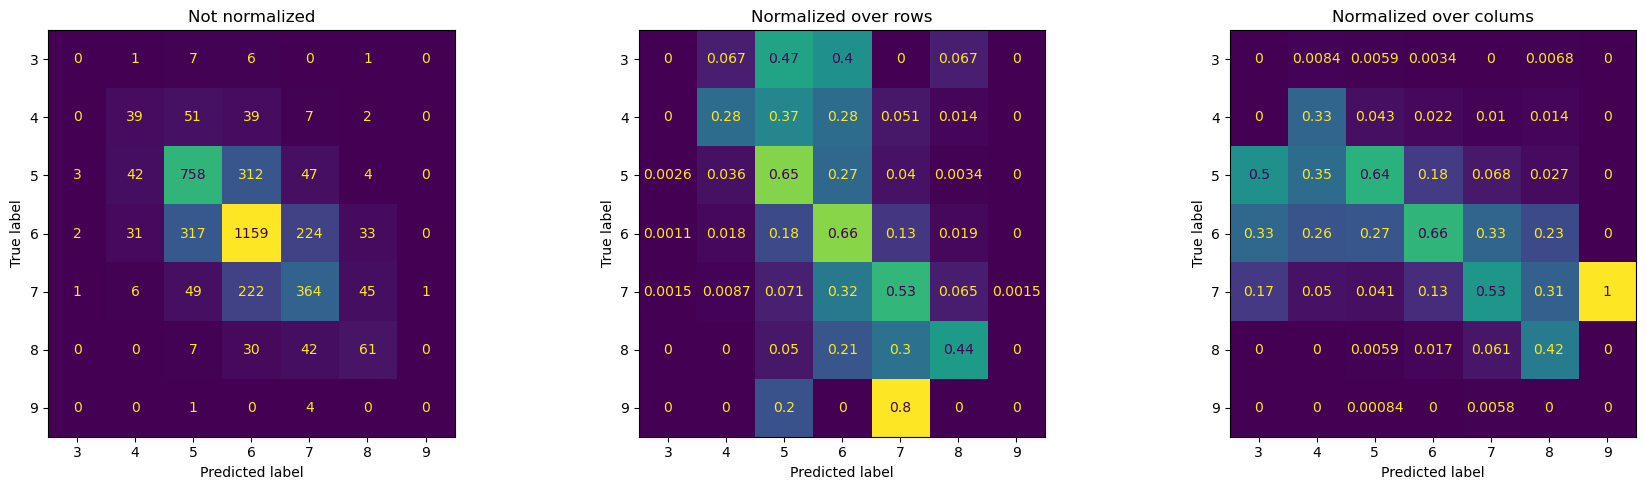

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import cross_val_predict
y_predict = cross_val_predict(knn_pipe,xtrn, ytrn, cv =5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

labels = np.unique(ytrn)

cm_none = confusion_matrix(ytrn, y_predict, labels=labels, normalize=None)
cm_true = confusion_matrix(ytrn, y_predict, labels=labels, normalize='true')
cm_pred = confusion_matrix(ytrn, y_predict, labels=labels, normalize='pred')


ConfusionMatrixDisplay(cm_none, display_labels = labels).plot(ax=axes[0], cmap='viridis', colorbar=False)
axes[0].set_title("Not normalized")

ConfusionMatrixDisplay(cm_true, display_labels = labels).plot(ax=axes[1], cmap='viridis', colorbar=False)
axes[1].set_title("Normalized over rows")

ConfusionMatrixDisplay(cm_pred, display_labels = labels).plot(ax=axes[2], cmap='viridis', colorbar=False)
axes[2].set_title("Normalized over colums")


plt.tight_layout()
plt.show()


### Transform Layer

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def y_transformer(target):
    return np.clip(np.round(target),1, 10)

y_transformer = FunctionTransformer(y_transformer, validate = True)

xdata_transform = make_pipeline(StandardScaler())




KNR_reg1 = TransformedTargetRegressor( 
       regressor = KNeighborsRegressor(n_neighbors = 1),
       transformer = y_transformer
       )

KNR_reg10 = TransformedTargetRegressor( 
       regressor = KNeighborsRegressor(n_neighbors = 10),
       transformer = y_transformer
       )

SVM = TransformedTargetRegressor( 
       regressor = SVR(),
       transformer = y_transformer
       )

Random_reg = TransformedTargetRegressor( 
       regressor = RandomForestRegressor(max_depth=2, random_state=42),
       transformer = y_transformer
       )

Linear_reg = TransformedTargetRegressor( 
       regressor = LinearRegression(),
       transformer = y_transformer
       )

KNN1 = KNeighborsClassifier(n_neighbors=1)

KNN10 = KNeighborsClassifier(n_neighbors=10)


### Model definition

In [ ]:
def run_models(trndata, trntarget, testdata, transformer):
    models = {
        "KNN Classifier(1)": KNN1,
        "KNN Regressor(1)": KNR_reg1,
        "KNN Classifier(10)": KNN10,
        "KNN Regressor(10)": KNR_reg10,
        "Random Forrest Regressor": Random_reg,
        "Linear Regression": Linear_reg,
        "SVM Regressor": SVM
       
    }

    mae_scorer = make_scorer(mean_absolute_error)
    rmse_scorer = make_scorer(root_mean_squared_error)

    tst_predict = {}
    cross_val_scores = {}
    cv_predict = {}

    pipelines = {
        name: make_pipeline(transformer, model)
        for name, model in models.items()
    }

    for name, pipe in pipelines.items():
        pipe.fit(trndata, trntarget)
        y_pred = pipe.predict(testdata)
        tst_predict[name] = y_pred
        
        scores_mae = cross_val_score(pipe, trndata, trntarget, cv=5, scoring=mae_scorer)
        scores_rmse = cross_val_score(pipe, trndata, trntarget, cv=5, scoring=rmse_scorer)
        
        cross_val_scores[name] = {
            "MAE": np.mean(scores_mae),
            "RMSE": np.mean(scores_rmse),
        }

        y_predictCV = cross_val_predict(pipe, trndata, trntarget, cv=5)
        cv_predict[name] = y_predictCV

    return pd.DataFrame(tst_predict), pd.Series(cross_val_scores), pd.Series(cv_predict)

### Model Result

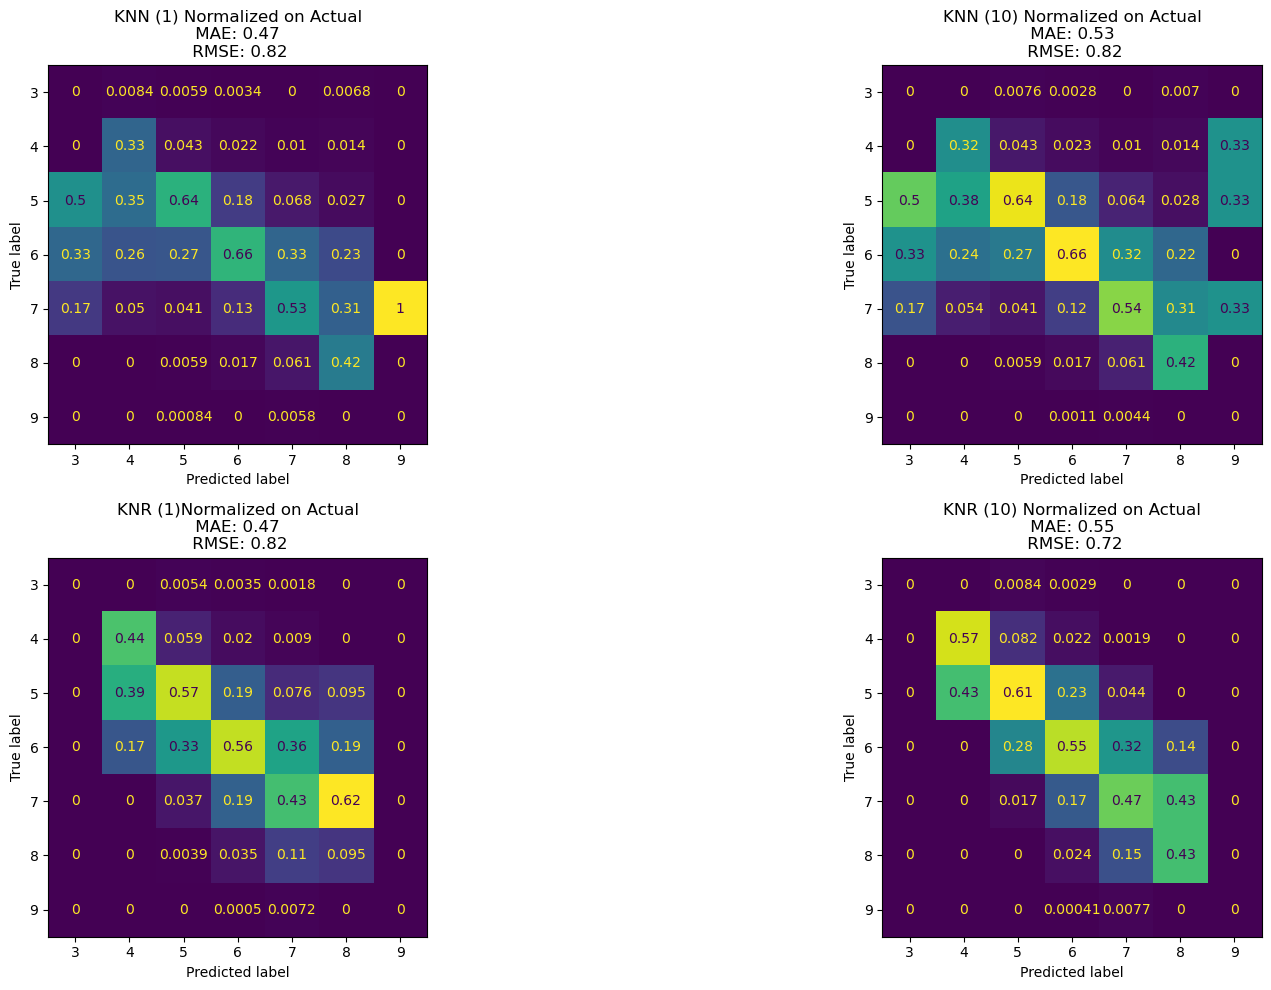

In [12]:
normalize_param = 'pred'

models = [
'KNN Classifier(1)', 
'KNN Regressor(1)', 
'KNN Classifier(10)', 
'KNN Regressor(10)', 
'Random Forrest Regressor', 
'Linear Regression', 
'SVM Regressor']
results = []

tst_predict, cross_val_scores, cv_predict = run_models(xtrn, ytrn, xtst, xdata_transform)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
labels = np.unique(ytrn)

for i in range(len(models)):
    results.append(confusion_matrix(ytrn, np.round(cv_predict[models[i]]), labels=labels, normalize=normalize_param))

ConfusionMatrixDisplay(results[0], display_labels = labels).plot(ax=axes[0,0], cmap='viridis', colorbar=False)
axes[0,0].set_title(f"KNN (1) Normalized on Actual\n MAE: {cross_val_scores['KNN Classifier(1)']['MAE']:.2f} \n RMSE: {cross_val_scores['KNN Classifier(1)']['RMSE']:.2f}")

ConfusionMatrixDisplay(results[1], display_labels = labels).plot(ax=axes[0,1], cmap='viridis', colorbar=False)
axes[0,1].set_title(f"KNN (10) Normalized on Actual\n MAE: {cross_val_scores['KNN Classifier(10)']['MAE']:.2f} \n RMSE: {cross_val_scores['KNN Classifier(10)']['RMSE']:.2f}")

ConfusionMatrixDisplay(results[2], display_labels = labels).plot(ax=axes[1,0], cmap='viridis', colorbar=False)
axes[1,0].set_title(f"KNR (1)Normalized on Actual\n MAE: {cross_val_scores['KNN Regressor(1)']['MAE']:.2f} \n RMSE: {cross_val_scores['KNN Regressor(1)']['RMSE']:.2f}")

ConfusionMatrixDisplay(results[3], display_labels = labels).plot(ax=axes[1,1], cmap='viridis', colorbar=False)
axes[1,1].set_title(f"KNR (10) Normalized on Actual\n MAE: {cross_val_scores['KNN Regressor(10)']['MAE']:.2f} \n RMSE: {cross_val_scores['KNN Regressor(10)']['RMSE']:.2f}")

plt.tight_layout()

### Optimizing

In [41]:
from sklearn.model_selection import GridSearchCV

k = [1,2,3,4,5,6,7,8,9,10,15,20]

KNR_GridCV = TransformedTargetRegressor( 
       regressor = KNeighborsRegressor(),
       transformer = y_transformer)

full_pipeline = make_pipeline(
    xdata_transform,KNR_GridCV)

parameters = {'transformedtargetregressor__regressor__n_neighbors': k}

grid_search = GridSearchCV(full_pipeline, parameters, cv=3,
                           scoring='neg_mean_absolute_error')
grid_search.fit(xtrn, ytrn)
grid_search.best_params_

{'transformedtargetregressor__regressor__n_neighbors': 1}

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["rank_test_score","param_transformedtargetregressor__regressor__n_neighbors","mean_test_score","split0_test_score","split1_test_score","split2_test_score"]]

scores = ["MAE_total", "MAE_split1", "MAE_split2", "MAE_split3"]
cv_res.columns = ["Rank", "n_neighbors"] + scores


cv_res[scores] = -cv_res[scores].astype(np.float16)
cv_res.head(20)

,Rank,n_neighbors,MAE_total,MAE_split1,MAE_split2,MAE_split3
0,1,1,0.506348,0.491699,0.528320,0.498535
1,2,2,0.532715,0.527832,0.536133,0.534668
3,3,4,0.546875,0.536133,0.546875,0.558594
2,4,3,0.548340,0.533203,0.549805,0.561035
4,5,5,0.548340,0.537598,0.552734,0.554688
5,6,6,0.548340,0.540039,0.549805,0.555176
6,7,7,0.548828,0.541016,0.551270,0.554688
7,8,8,0.551270,0.542969,0.557129,0.553223
8,9,9,0.551758,0.541016,0.561035,0.554199
9,10,10,0.552246,0.542480,0.559570,0.554199
